<a href="https://colab.research.google.com/github/neha-dhananju/3/blob/main/Copy_of_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report
from google.colab import drive
drive.mount('/content/drive')

# Import data
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/project1/train/rgb.csv')
data.head()

Mounted at /content/drive


pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [ ]:
data1=data.head(100)

In [ ]:
y = data1['label']
x = data1.drop(columns = ['label'])

In [ ]:
data.shape

(10015, 2353)

In [ ]:
data1.shape

(100, 2353)

In [ ]:
#EDA
tabular_data = pd.read_csv('/content/drive/My Drive/project1/train/ipcsv.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
tabular_data.shape

(10015, 7)

In [ ]:
tb1=tabular_data.head(100)

In [ ]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [ ]:
tb1.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}


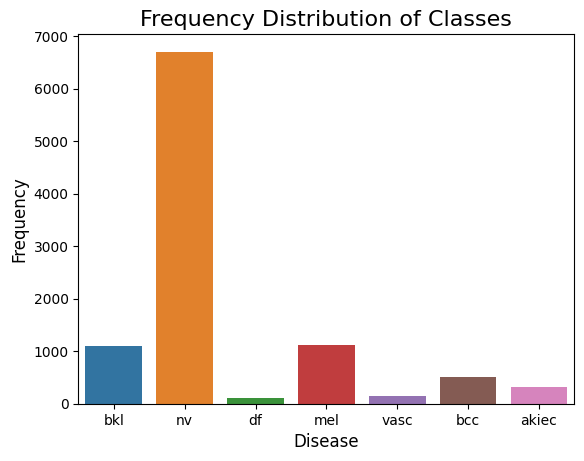

In [ ]:
# Frequency distribution of classses
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

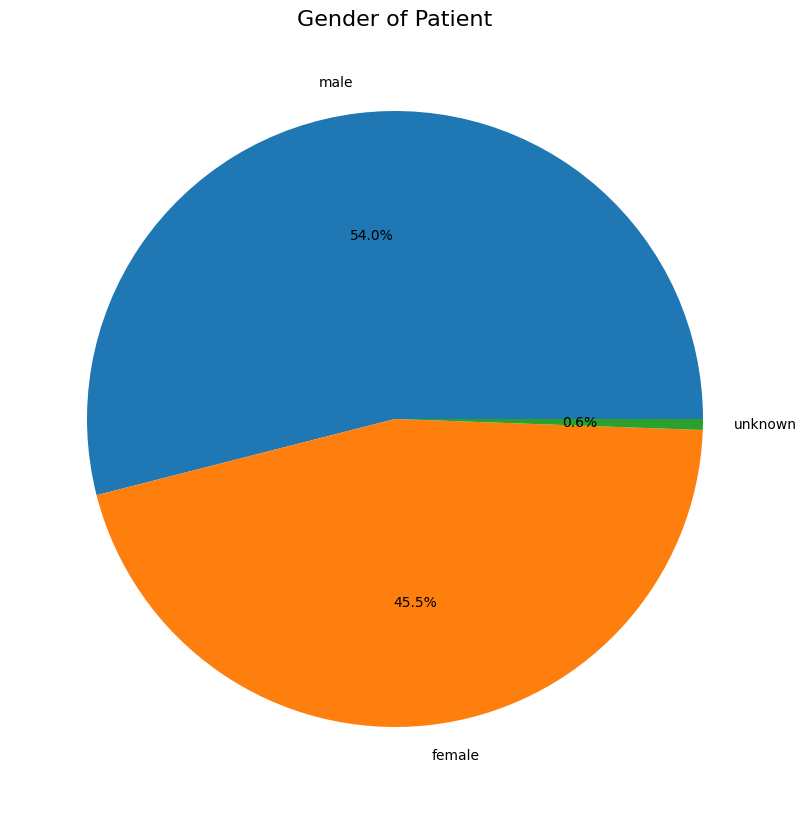

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)
plt.show()

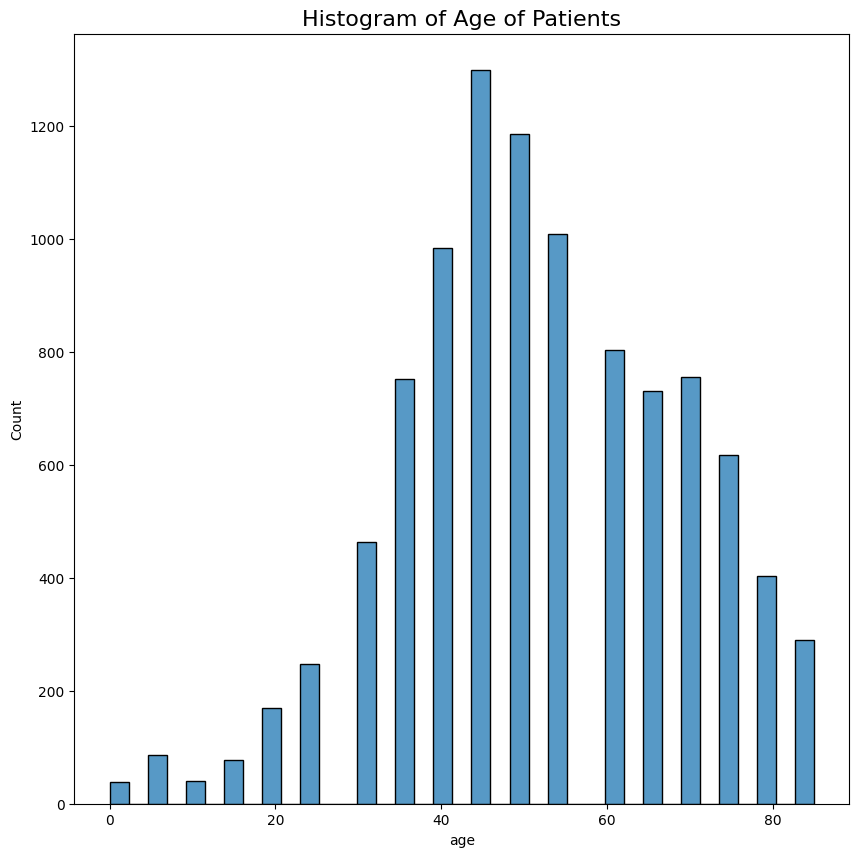

In [ ]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)
plt.show()

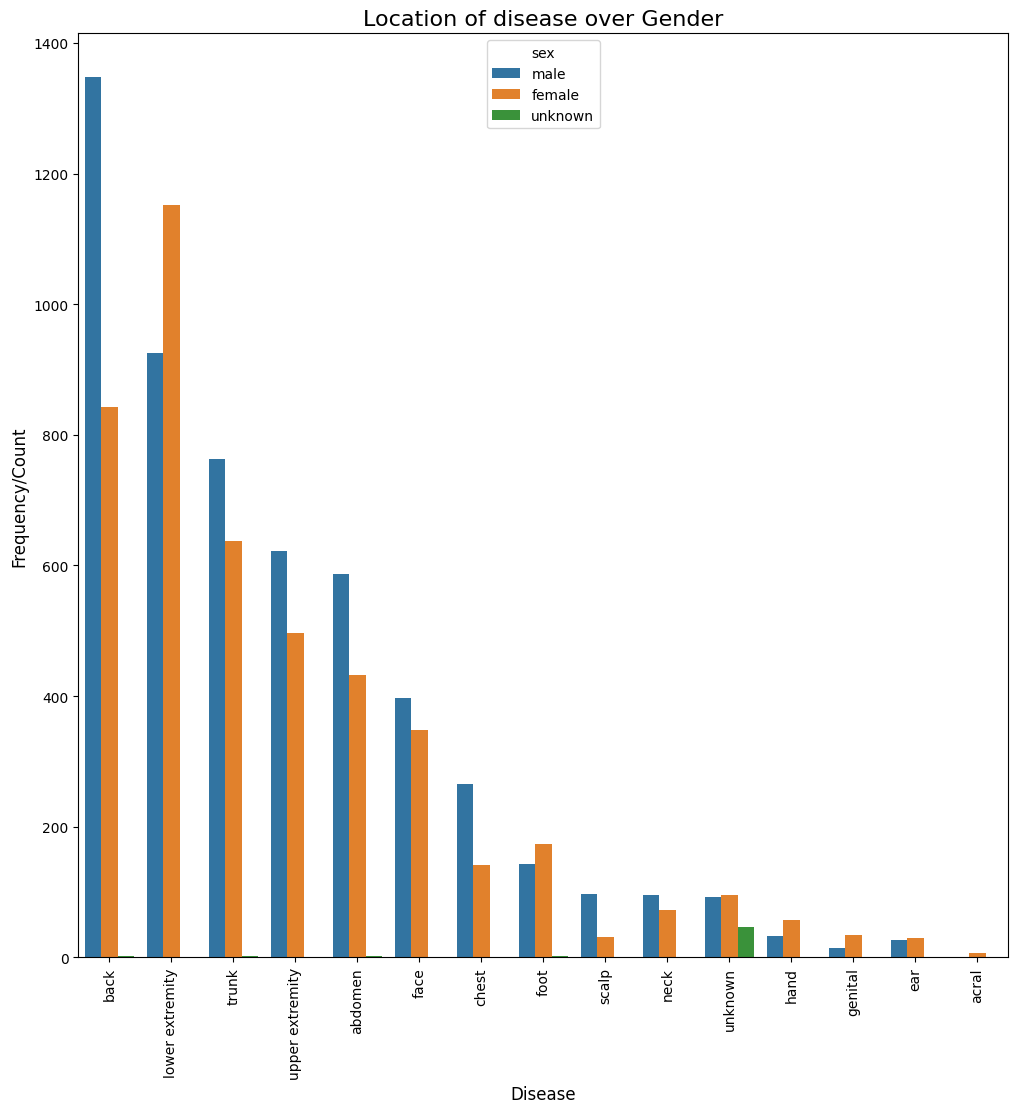

In [ ]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)
plt.show()


In [ ]:
# Over sampling
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (198, 28, 28, 3)


In [ ]:
print('Shape of Y :',y.shape)

Shape of Y : (198,)


In [ ]:
# Standardization and splitting of data

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
# custom model

from keras import backend as K
from keras.layers import Layer,InputSpec,Input,BatchNormalization,MaxPooling2D,concatenate,Activation,Dropout
import keras.layers as kl
import tensorflow as tf
from tensorflow.keras import Model



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0,ResNet50,MobileNetV2,ResNet101
from tensorflow.keras import layers

inputs = layers.Input(shape=(28, 28, 3))
model = ResNet101(include_top=False, input_tensor=inputs, weights="imagenet")
model.trainable = False

# Rebuild top
conv = MaxPooling2D(pool_size=(2, 2),padding="same")(model.output)
conv = (BatchNormalization()(conv))


attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv=Activation("relu")(conv)
conv= Dropout(0.5)(conv)

conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(7, activation="softmax")(conv))

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.models import Model
model = Model(inputs=inputs, outputs=conv,name="ResNet101")
model.summary()

Model: "ResNet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 34, 34, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 14, 14, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 14, 14, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [ ]:
#model training
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)




In [ ]:
Y_train.shape

(158,)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.3,
                    batch_size = 32,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 1: saving model to best_model.h5
4/4 [==============================] - 63s 13s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.7829 - val_accuracy: 0.5208
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9909    
Epoch 2: saving model to best_model.h5
4/4 [==============================] - 25s 7s/step - loss: 0.0900 - accuracy: 0.9909 - val_loss: 3.0492 - val_accuracy: 0.5208
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9727
Epoch 3: saving model to best_model.h5
4/4 [==============================] - 25s 7s/step - loss: 0.2741 - accuracy: 0.9727 - val_loss: 6.5796 - val_accuracy: 0.5208
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 1.1931e-06 - accuracy: 1.0000
Epoch 4: saving model to best_model.h5
4/4 [==============================] - 27s 8s/step - loss: 1.1931e-06 - accuracy: 1.00

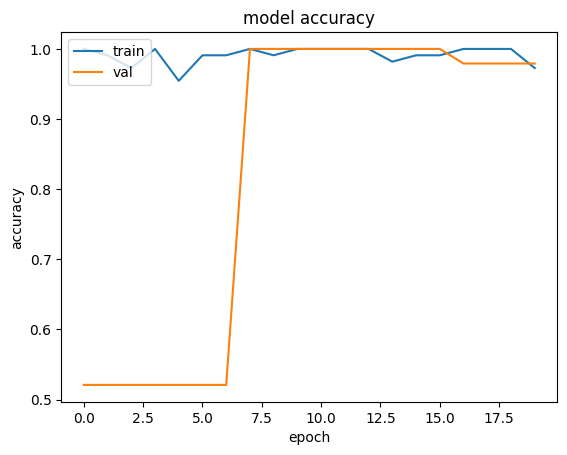

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

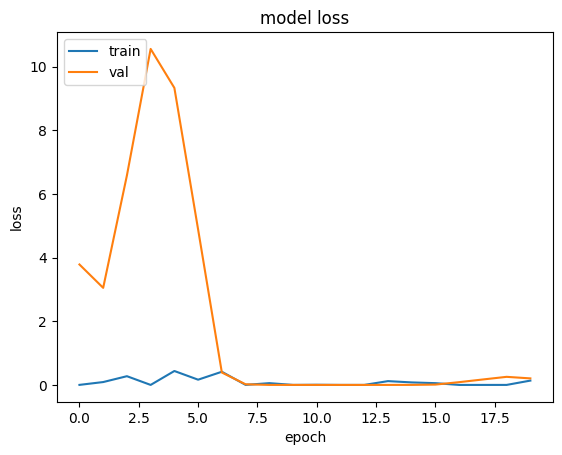

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
y_true = np.array(Y_test)
y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
print(y_true)
print(y_pred)

2/2 [==============================] - 4s 140ms/step
[4 2 2 2 4 4 2 2 2 4 2 2 2 4 4 4 4 2 4 2 2 2 2 2 2 4 2 2 4 2 2 4 2 4 4 4 4
 4 2 4]
[4 2 2 2 4 4 2 2 2 4 2 2 2 4 4 4 4 2 4 2 2 2 2 2 2 4 2 2 4 4 2 4 2 4 4 4 4
 4 2 4]


In [ ]:
pred=model.predict(X_test)
pred

2/2 [==============================] - 1s 346ms/step


array([[3.5453229e-29, 1.3428586e-28, 8.7657204e-15, 1.5166099e-29,
        9.9999994e-01, 5.2421041e-30, 2.4036751e-30],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [3.5453229e-29, 1.3428586e-28, 8.7657204e-15, 1.5166099e-29,
        9.9999994e-01, 5.2421041e-30, 2.4036751e-30],
       [3.5453229e-29, 1.3428586e-28, 8.7657204e-15, 1.5166099e-29,
        9.9999994e-01, 5.2421041e-30, 2.4036751e-30],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, 0.0000000e+00,
        3.2400593e-35, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0

In [ ]:
classes_labels

[4, 6, 2, 1, 5, 0, 3]

In [ ]:
report = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.95      0.98        22
           4       0.95      1.00      0.97        18

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



In [ ]:
cm=confusion_matrix(y_true,y_pred,labels=classes_labels)
print(confusion_matrix(y_true,y_pred,labels=classes_labels))


[[18  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0 21  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


<Axes: >

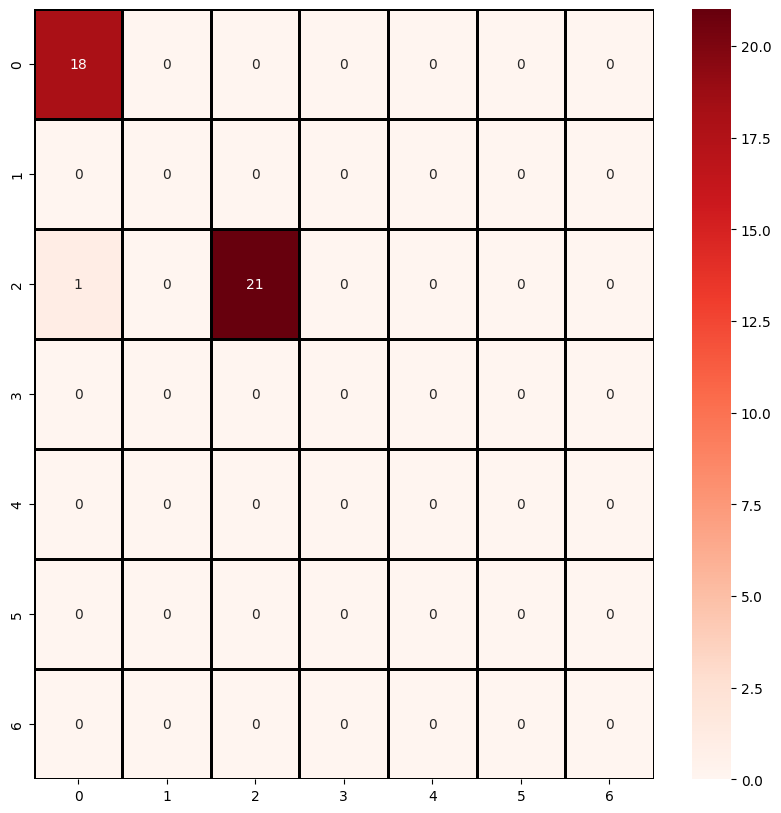

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')


In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

2/2 - 1s - loss: 0.1436 - accuracy: 0.9750 - 812ms/epoch - 406ms/step


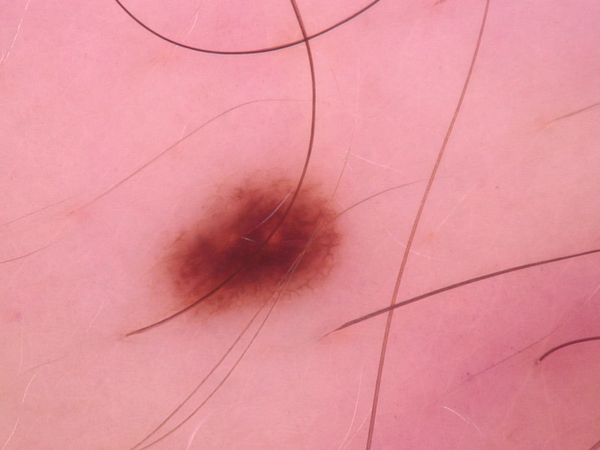

{('mel', 'melanoma')}


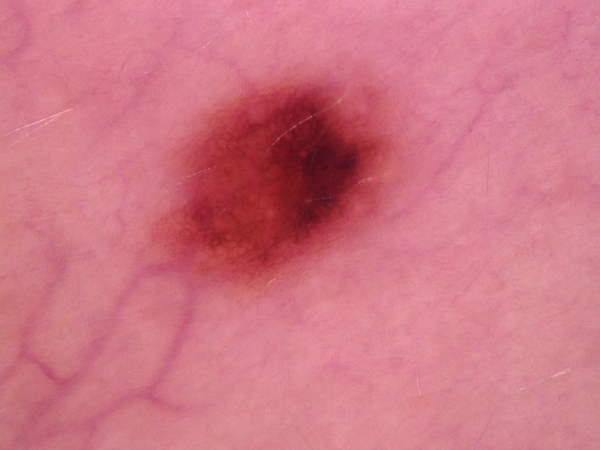

{('df', 'dermatofibroma')}


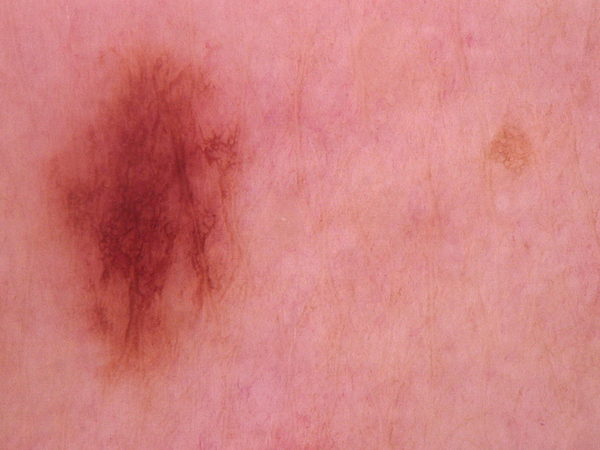

{('mel', 'melanoma')}


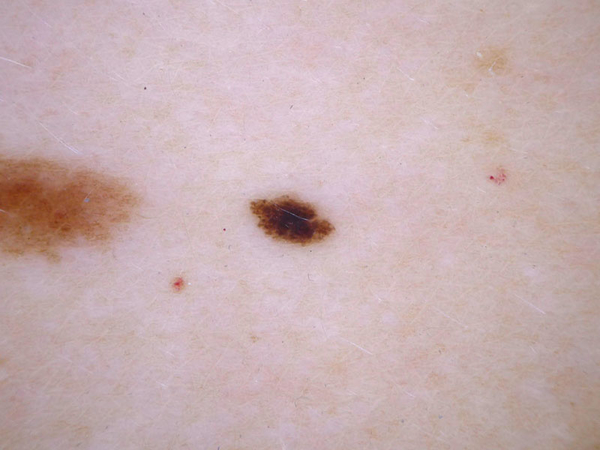

{('bkl', 'benign keratosis-like lesions')}


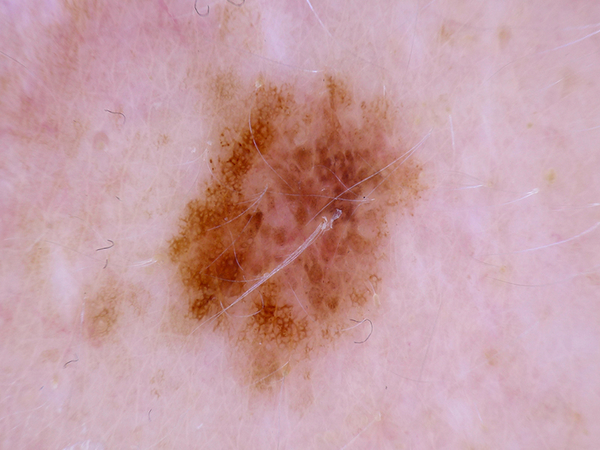

{('mel', 'melanoma')}


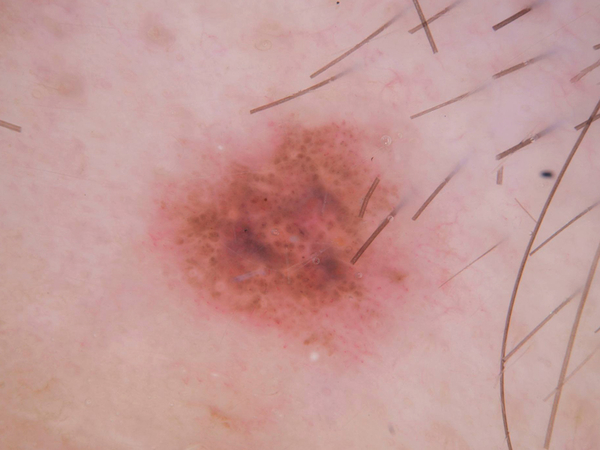

{('bcc', ' basal cell carcinoma')}


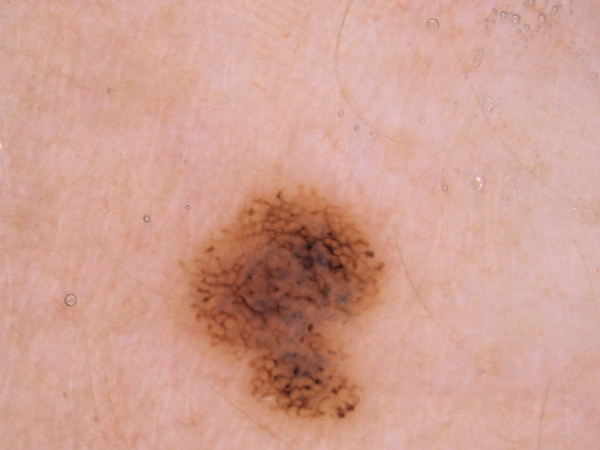

{('bkl', 'benign keratosis-like lesions')}


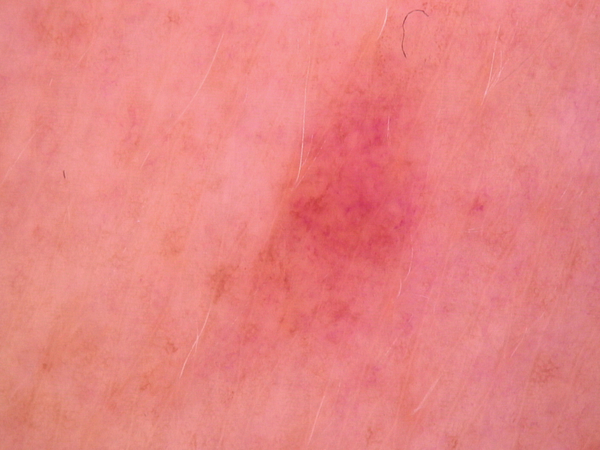

{('bkl', 'benign keratosis-like lesions')}


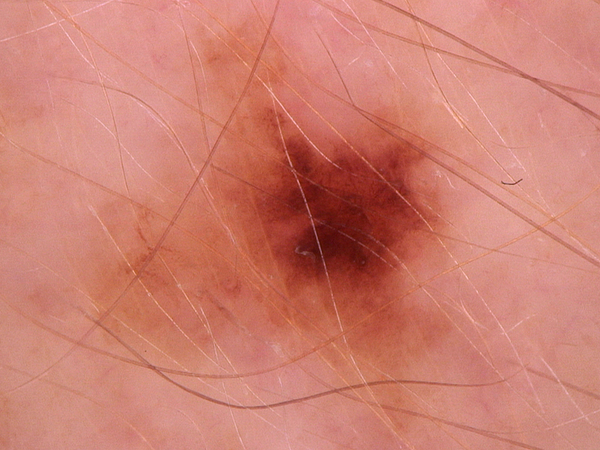

{('vasc', ' pyogenic granulomas and hemorrhage')}


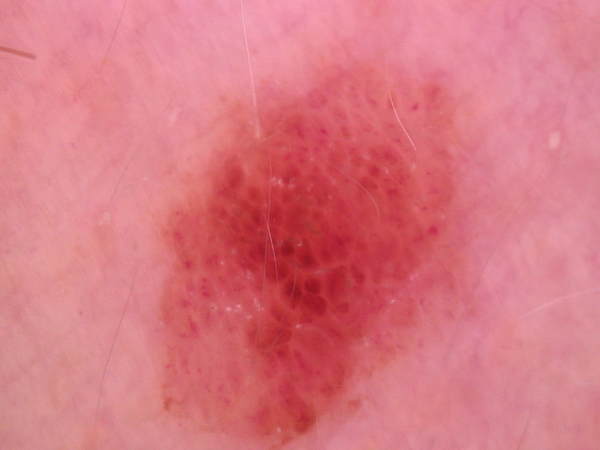

{('nv', ' melanocytic nevi')}


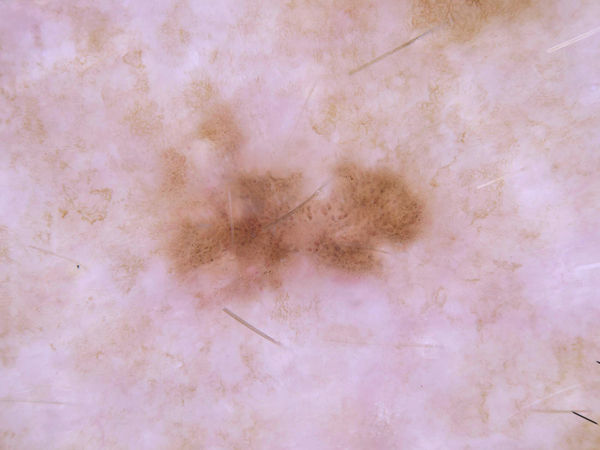

{('bcc', ' basal cell carcinoma')}


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import random  # Import the random module

# Assuming you have a list of classes
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')} # Replace with your actual class names

srcdir = '/content/drive/My Drive/project1/sck'
count = 0

for temp in os.listdir(srcdir):
    img_path = os.path.join(srcdir, temp)

    # Read the image
    img = cv2.imread(img_path)

    # Display the image
    cv2_imshow(img)

    # Preprocess the image if necessary (e.g., resize)
    img = cv2.resize(img, (28, 28))

    # Simulate a random prediction from available classes
    predicted_class = random.choice(classes)

    # Display the randomly predicted class
    print( {predicted_class})

    count += 1
    if count > 10:
        break  # Break after 10 images for demonstration
